In [2]:
import pickle
import torch
import numpy as np
import pandas as pd
import gpytorch
from sklearn.decomposition import PCA

## loading the data from ../train_generations.pkl
with open('../train_generations.pkl', 'rb') as f:
    data = pickle.load(f)
    print(type(data))
    data = pd.DataFrame(data)
 


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/zehaannaik/Library/Python/3.10/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/zehaannaik/Library/Python/3.10/lib/python/site-packages/traitlets/c

<class 'dict'>


In [3]:
for key in sorted(data.keys()):
        for next_key in sorted(data[key].keys()):
            if next_key == "responses":
                response_data = (data[key][next_key])
                if not response_data:
                    continue
                first_response = response_data[0]
                print("AAAAAAAAAAAAAA")
                print(first_response)
                token_embeddings = first_response[2] 
                print("BBBBBBBBBBBBBBB")
                print(token_embeddings)
                print("AAAAAAAAAAAAAA")
                
                

AAAAAAAAAAAAAA
('Trumpets and trombones are most commonly pitched at Bb.', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.08954261988401413, 0.0, -0.3505175709724426], tensor([[-2.8837,  6.8692,  1.1943,  ..., -1.6161, -0.4493, -2.8256]]), 0.0)
BBBBBBBBBBBBBBB
tensor([[-2.8837,  6.8692,  1.1943,  ..., -1.6161, -0.4493, -2.8256]])
AAAAAAAAAAAAAA
AAAAAAAAAAAAAA
("Every good boy deserves favour' is a mnemonic in?", [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], tensor([[-2.5785,  2.5525,  3.6656,  ..., -5.7184, -2.0659, -1.0848]]), 0.0)
BBBBBBBBBBBBBBB
tensor([[-2.5785,  2.5525,  3.6656,  ..., -5.7184, -2.0659, -1.0848]])
AAAAAAAAAAAAAA
AAAAAAAAAAAAAA
('John Lewis', [0.0, 0.0], tensor([[ 2.9588,  2.2058,  3.7353,  ..., -5.1753, -2.8140,  1.6127]]), 0.0)
BBBBBBBBBBBBBBB
tensor([[ 2.9588,  2.2058,  3.7353,  ..., -5.1753, -2.8140,  1.6127]])
AAAAAAAAAAAAAA
AAAAAAAAAAAAAA
('een Elizabeth II has always had corgis as pets. She has owned 30 corgis in her lifetime, according

In [4]:
# Let's assume df is already in memory
def extract_embeddings(df, limit=None):
    embeddings = []
    
    for key in sorted(data.keys()):
        for next_key in sorted(data[key].keys()):
            if next_key == "responses":
                try:
                    response_data = data[key][next_key]
                    response_data = data[key][next_key]
                    if not response_data:
                        continue
                    first_response = response_data[0]
                    token_embeddings = response_data[0][2]

                    if isinstance(token_embeddings, torch.Tensor) and token_embeddings.ndim == 2:
                        sentence_embedding = token_embeddings.mean(dim=0)
                        embeddings.append(sentence_embedding.detach().cpu())
                        
                    else:
                        continue
                except Exception as e:
                    print(f"Error processing {key}: {e}")
                    
                if limit and len(embeddings) >= limit:
                    break

    return torch.stack(embeddings)

In [5]:
X = extract_embeddings(data, limit=500)

In [12]:
class GPLVMModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gplvm(X, latent_dim=2, n_inducing=30, num_iter=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Use SVD-based PCA to initialize latent space
    U, S, V = torch.pca_lowrank(X, q=latent_dim)
    Z_init = X @ V[:, :latent_dim]
    Z_init = Z_init.to(device)

    # Target: only one dimension for now (1D regression problem)
    y = X[:, 0].to(device)

    # Define inducing points
    inducing_points = Z_init[:n_inducing]

    # Model
    model = GPLVMModel(inducing_points).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.01)

    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(Z_init)
        loss = -mll(output, y)
        loss.backward()
        if i % 50 == 0:
            print(f"Iter {i}: loss = {loss.item():.4f}")
        optimizer.step()

    return model, likelihood, Z_init, y



In [16]:
# Assume X is your (n_samples, embedding_dim) tensor
model, likelihood, Z_latent, y_observed = train_gplvm(X, latent_dim=2, num_iter=300)


# Z_latent is the learned 2D latent representation of LLM outputs

Iter 0: loss = 3.3278
Iter 50: loss = 2.5606
Iter 100: loss = 2.2970
Iter 150: loss = 2.1776
Iter 200: loss = 2.1126
Iter 250: loss = 2.0733


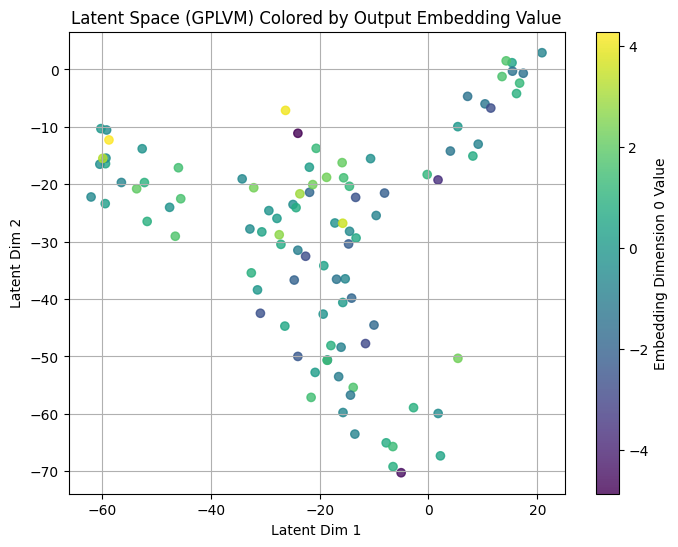

In [19]:
import matplotlib.pyplot as plt

Z_plot = Z_latent.detach().cpu()
y_plot = y_observed.detach().cpu()

x_vals = Z_plot[:, 0].tolist()
y_vals = Z_plot[:, 1].tolist()
c_vals = y_plot.tolist()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_vals, y_vals, c=c_vals, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, label="Embedding Dimension 0 Value")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.title("Latent Space (GPLVM) Colored by Output Embedding Value")
plt.grid(True)
plt.show()



In [21]:
model.eval()
likelihood.eval()

Z_np = Z_latent.detach().cpu()

# Create a grid in 2D latent space
x_min, x_max = Z_np[:, 0].min(), Z_np[:, 0].max()
y_min, y_max = Z_np[:, 1].min(), Z_np[:, 1].max()

xx, yy = torch.meshgrid(
    torch.linspace(x_min, x_max, 100),
    torch.linspace(y_min, y_max, 100),
    indexing='ij'
)
Z_grid = torch.stack([xx.ravel(), yy.ravel()], dim=-1).to(Z_latent.device)

# Predict
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(Z_grid))
    mean = preds.mean.cpu().view(100, 100)
    stddev = preds.stddev.cpu().view(100, 100)


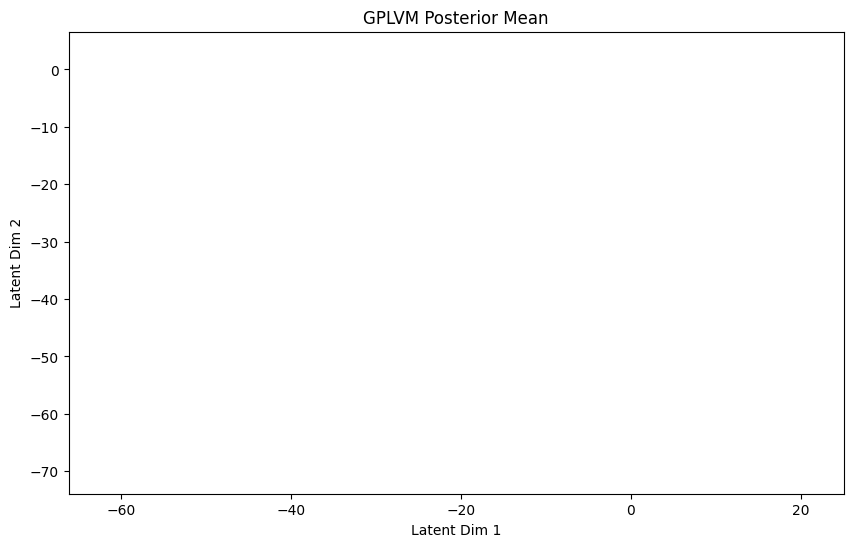

In [29]:
plt.figure(figsize=(10, 6))
# plt.contourf(xx, yy, mean, levels=30, cmap="viridis")
# plt.colorbar(label="Predicted Mean")
x_vals = Z_plot[:, 0].tolist()
y_vals = Z_plot[:, 1].tolist()
plt.scatter(x_vals, y_vals, c='white', s=10, alpha=0.7)
plt.title("GPLVM Posterior Mean")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.show()